# Denoising Diffusion Probabilistic Model (**DDPM**) using PyTorch - with **MNIST** Dataset

In [1]:
!pip install torchinfo

## Import the required libraries

In [2]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

In [3]:
print('PyTorch version:', torch.__version__)
print('Torchvision version:', torchvision.__version__)


PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121


## Define the device

In [4]:
!nvidia-smi

Sat Jun  8 17:16:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GPU name: Tesla T4 

Device is: cuda 

Total number of GPUs: 1


## Load the **MNIST** Dataset

In [6]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [7]:
training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16013212.16it/s]


Extracting ./data_src/MNIST/raw/train-images-idx3-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 487028.57it/s]


Extracting ./data_src/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4380917.37it/s]


Extracting ./data_src/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2985976.30it/s]

Extracting ./data_src/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_src/MNIST/raw



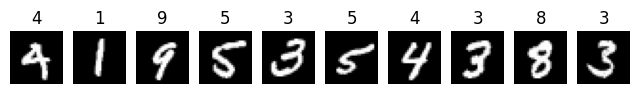

In [8]:
# show 10 randomly selected samples from the training dataset
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='gray')
    ax.set_title(int(training_dataset.targets[inx]), fontsize=12)
    ax.axis(False)

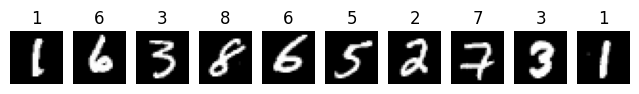

In [9]:
# show 10 randomly selected samples from the test dataset
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='gray')
    ax.set_title(int(test_dataset.targets[inx]), fontsize=12)
    ax.axis(False)

## Define dataloaders

In [10]:
training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

## Define Linear_Variance_Scheduler

In [11]:
class Linear_Variance_Scheduler:
  def __init__(self, time_steps, beta_start, beta_end, device='cuda'):

          self.time_steps = time_steps
          self.beta_start = beta_start
          self.beta_end = beta_end
          self.device = device

          self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
          self.alphas = 1 - self.betas
          self.alpha_bar = torch.cumprod(self.alphas, dim=0)
          self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
          self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

  def diffusion_process(self, x, noise, t):
          sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
          sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
          return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

  def ddpm_sampling(self, model, num_samples, channels, img_size):
          model.eval()
          with torch.inference_mode():
              x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
              collect = []
              for i in tqdm(reversed(range(self.time_steps))):
                  t = (torch.ones(num_samples) * i).long().to(self.device)
                  pred_noise = model(x, t)
                  alphas = self.alphas[t][:, None, None, None]
                  alpha_bar = self.alpha_bar[t][:, None, None, None]
                  betas = self.betas[t][:, None, None, None]
                  if i > 1:
                      noise = torch.randn_like(x)
                  else:
                      noise = torch.zeros_like(x)
                  x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                      torch.sqrt(betas) * noise
                  if (i+1) % 100 == 0 or i==0:
                      collect.append(x)
          return x, collect

## Forward process output


In [12]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

In [13]:
noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

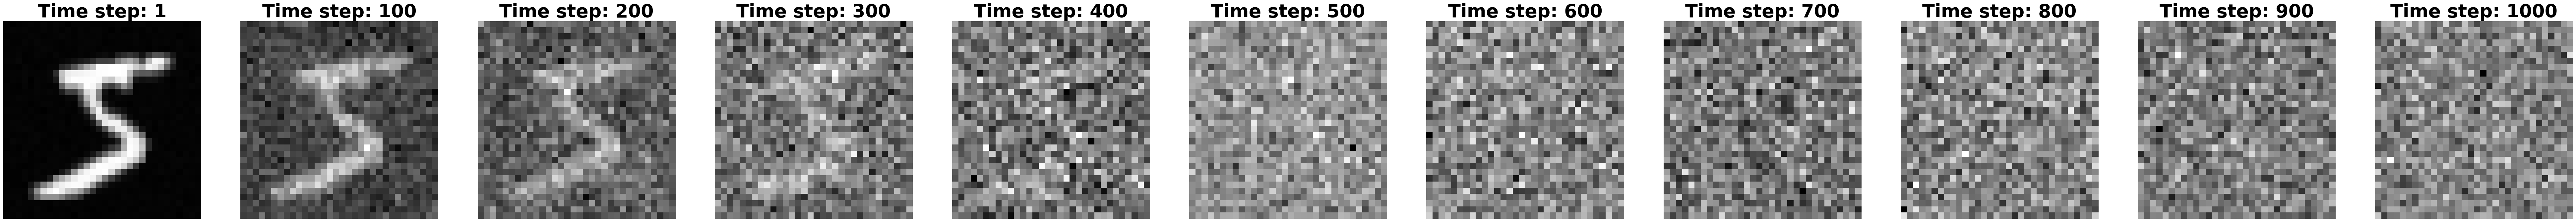

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for idx, img in enumerate(noisy_img_stack):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(f'Time step: {t_step[idx]+1}', fontsize=40, fontweight='bold')
    ax[idx].axis(False);

## Create ResBlock

In [15]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()

        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))

    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

## Create SelfAttentionBlock

In [16]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()

        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)

    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

## Create DownBlock

In [17]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()

        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

## Create UpBlock

In [18]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()

        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

## Create UNet architecture

In [19]:
class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()

        self.device = device
        self.t_emb_dim = t_emb_dim

        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)

        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)

        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb

    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)

        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

## Visualize UNet architecture

In [20]:
summary(UNet(t_emb_dim=256), input_size=[(64, 1, 32, 32), (64,)])

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [64, 1, 32, 32]           --
├─ResBlock: 1-1                               [64, 64, 32, 32]          --
│    └─Sequential: 2-1                        [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                       [64, 64, 32, 32]          640
│    │    └─GroupNorm: 3-2                    [64, 64, 32, 32]          128
│    │    └─SiLU: 3-3                         [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                       [64, 64, 32, 32]          36,928
│    │    └─GroupNorm: 3-5                    [64, 64, 32, 32]          128
├─DownBlock: 1-2                              [64, 128, 16, 16]         --
│    └─Sequential: 2-2                        [64, 128, 16, 16]         --
│    │    └─MaxPool2d: 3-6                    [64, 64, 16, 16]          --
│    │    └─ResBlock: 3-7                     [64, 64, 16, 16]          74,112
│    │   

## Set up Linear_Variance_Scheduler, model (UNet), criterion (loss_function) and optimizer

In [22]:
ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Train UNet

In [23]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 20
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []

    for data, _ in tqdm(training_dataloader):
        model.train()
        data = data.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()

    with torch.inference_mode():
        for data, _ in tqdm(test_dataloader):
            model.eval()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)

    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')

100%|██████████| 156/156 [00:16<00:00,  9.56it/s]


Epoch: 1/20	| Training loss: 0.0629 |   Test loss: 0.0317


100%|██████████| 156/156 [00:16<00:00,  9.32it/s]


Epoch: 2/20	| Training loss: 0.0288 |   Test loss: 0.0263


100%|██████████| 156/156 [00:16<00:00,  9.58it/s]


Epoch: 3/20	| Training loss: 0.0246 |   Test loss: 0.0234


100%|██████████| 156/156 [00:16<00:00,  9.53it/s]


Epoch: 4/20	| Training loss: 0.0222 |   Test loss: 0.0204


100%|██████████| 156/156 [00:16<00:00,  9.52it/s]


Epoch: 5/20	| Training loss: 0.0206 |   Test loss: 0.0203


100%|██████████| 156/156 [00:16<00:00,  9.63it/s]


Epoch: 6/20	| Training loss: 0.0195 |   Test loss: 0.0198


100%|██████████| 156/156 [00:16<00:00,  9.49it/s]


Epoch: 7/20	| Training loss: 0.0191 |   Test loss: 0.0185


100%|██████████| 156/156 [00:16<00:00,  9.54it/s]


Epoch: 8/20	| Training loss: 0.0184 |   Test loss: 0.0178


100%|██████████| 156/156 [00:16<00:00,  9.50it/s]


Epoch: 9/20	| Training loss: 0.0180 |   Test loss: 0.0181


100%|██████████| 156/156 [00:16<00:00,  9.58it/s]


Epoch: 10/20	| Training loss: 0.0176 |   Test loss: 0.0175


100%|██████████| 156/156 [00:16<00:00,  9.58it/s]


Epoch: 11/20	| Training loss: 0.0176 |   Test loss: 0.0183


100%|██████████| 156/156 [00:16<00:00,  9.53it/s]


Epoch: 12/20	| Training loss: 0.0173 |   Test loss: 0.0168


100%|██████████| 156/156 [00:16<00:00,  9.59it/s]


Epoch: 13/20	| Training loss: 0.0169 |   Test loss: 0.0163


100%|██████████| 156/156 [00:16<00:00,  9.33it/s]


Epoch: 14/20	| Training loss: 0.0167 |   Test loss: 0.0164


100%|██████████| 156/156 [00:16<00:00,  9.59it/s]


Epoch: 15/20	| Training loss: 0.0168 |   Test loss: 0.0165


100%|██████████| 156/156 [00:16<00:00,  9.51it/s]


Epoch: 16/20	| Training loss: 0.0164 |   Test loss: 0.0167


100%|██████████| 156/156 [00:16<00:00,  9.60it/s]


Epoch: 17/20	| Training loss: 0.0162 |   Test loss: 0.0163


100%|██████████| 156/156 [00:16<00:00,  9.63it/s]


Epoch: 18/20	| Training loss: 0.0163 |   Test loss: 0.0162


100%|██████████| 156/156 [00:16<00:00,  9.35it/s]


Epoch: 19/20	| Training loss: 0.0163 |   Test loss: 0.0157


100%|██████████| 156/156 [00:16<00:00,  9.58it/s]

Epoch: 20/20	| Training loss: 0.0158 |   Test loss: 0.0159


## Plot losses

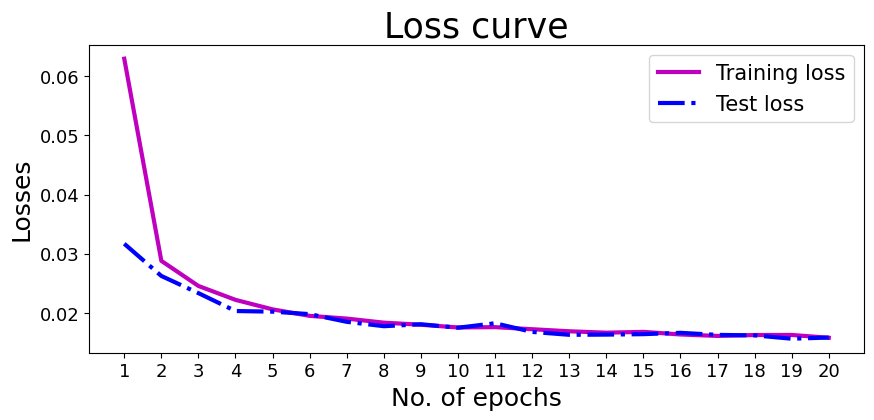

In [24]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(10, 4))
plt.plot(N, training_loss, 'm-', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-.', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=18)
plt.ylabel('Losses', fontsize=18)
plt.xticks(N, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15);

## Reverse process output

In [25]:
_, collect = ddpm.ddpm_sampling(model=model, num_samples=1, channels=1, img_size=32)


1000it [00:09, 105.75it/s]


In [26]:
step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1]


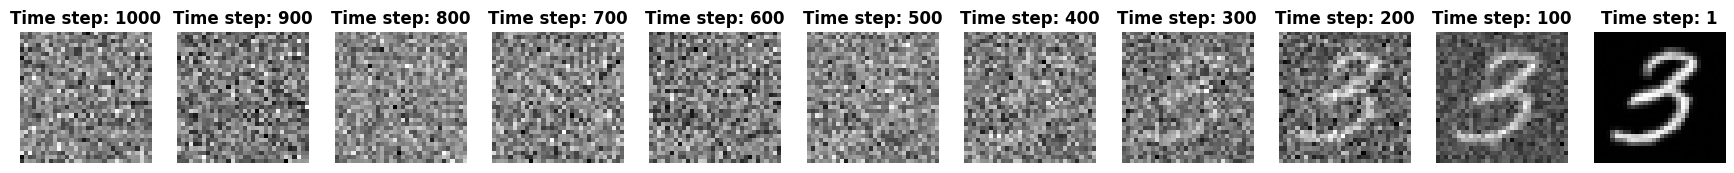

In [27]:
fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))

j = 0
for ax, _ in zip(axis.ravel(), range(11)):
    ax.imshow(collect[j][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {step[j]}', fontweight='bold')
    ax.axis(False)
    j += 1;

## Random sampling from noise

In [28]:
sampled_imgs, _ = ddpm.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32)


1000it [01:28, 11.31it/s]


In [29]:
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)


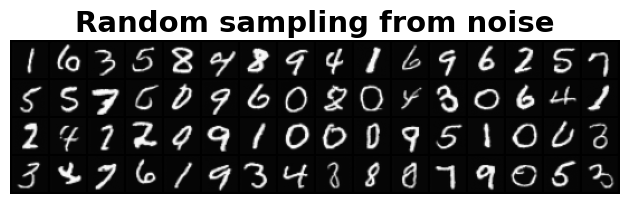

In [30]:
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Random sampling from noise', fontsize=21, fontweight='bold');